In [5]:
#Importing
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping

In [6]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

# Data preprocessing

In [7]:
# ... existing code ...

def get_data(normalize, train_data, test_data):
    train_data, test_data = train_data.align(test_data, join='outer', axis=1)

    # Convert booleans to int64
    boolean_columns = train_data.select_dtypes(include=[bool])
    train_data[boolean_columns.columns] = boolean_columns.astype('int64')
    test_data[boolean_columns.columns] = test_data[boolean_columns.columns].astype('int64')

    # Drop unnecessary columns
    train_data = train_data.drop(['BsmtFinSF1', 'BsmtFinSF2', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtUnfSF', 'GarageArea', 'GarageCars', 'TotalBsmtSF'], axis=1)
    test_data = test_data.drop(['BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 'GarageCond', 'GarageFinish', 'GarageQual', 'GarageType'], axis=1)

    # OneHotEncoding
    train_data = pd.get_dummies(train_data)
    test_data = pd.get_dummies(test_data)

    # Align train and test data
    train_data, test_data = train_data.align(test_data, join='left', axis=1, fill_value=0)

    # Handle missing values by filling them with the median
    train_data = train_data.fillna(train_data.median(numeric_only=True))
    test_data = test_data.fillna(test_data.median(numeric_only=True))

    # Separate the target variable
    sale_price = train_data['SalePrice']
    train_data = train_data.drop('SalePrice', axis=1)

    # Select top 20 features based on correlation with SalePrice
    correlation = train_data.corrwith(sale_price).abs().sort_values(ascending=False)
    top_features = correlation.head(20).index

    # Print the top features
    print("Top 20 features based on correlation with SalePrice:")
    print(top_features)

    train_data = train_data[top_features]
    test_data = test_data[top_features]

    # Scaling
    if normalize:
        scaler = MinMaxScaler()
        train_data = scaler.fit_transform(train_data)
        test_data = scaler.transform(test_data)

    # Train test split
    X_train, X_test, y_train, y_test = train_test_split(train_data, sale_price, random_state=42)
    return X_train, X_test, y_train, y_test, test_data, top_features

# Model building
X_train, X_test, y_train, y_test, test_data, top_features = get_data(False, train_data, test_data)

# Now you can print top_features outside the function
print("Top 20 features used in the model:")
print(top_features)

# ... existing code ...

Top 20 features based on correlation with SalePrice:
Index(['OverallQual', 'GrLivArea', '1stFlrSF', 'ExterQual_TA', 'FullBath',
       'BsmtQual_Ex', 'TotRmsAbvGrd', 'YearBuilt', 'KitchenQual_TA',
       'YearRemodAdd', 'KitchenQual_Ex', 'Foundation_PConc', 'MasVnrArea',
       'Fireplaces', 'GarageYrBlt', 'ExterQual_Gd', 'BsmtQual_TA',
       'ExterQual_Ex', 'BsmtFinType1_GLQ', 'HeatingQC_Ex'],
      dtype='object')
Top 20 features used in the model:
Index(['OverallQual', 'GrLivArea', '1stFlrSF', 'ExterQual_TA', 'FullBath',
       'BsmtQual_Ex', 'TotRmsAbvGrd', 'YearBuilt', 'KitchenQual_TA',
       'YearRemodAdd', 'KitchenQual_Ex', 'Foundation_PConc', 'MasVnrArea',
       'Fireplaces', 'GarageYrBlt', 'ExterQual_Gd', 'BsmtQual_TA',
       'ExterQual_Ex', 'BsmtFinType1_GLQ', 'HeatingQC_Ex'],
      dtype='object')


In [8]:
#X_train, X_test, y_train, y_test, test_data = get_data(False)
format(train_data.shape)

'(1460, 81)'

In [9]:
if 'Id' in train_data.columns:
    train_data = train_data.drop('Id', axis=1)
train_data.head(3)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [10]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


<Axes: xlabel='SalePrice', ylabel='Count'>

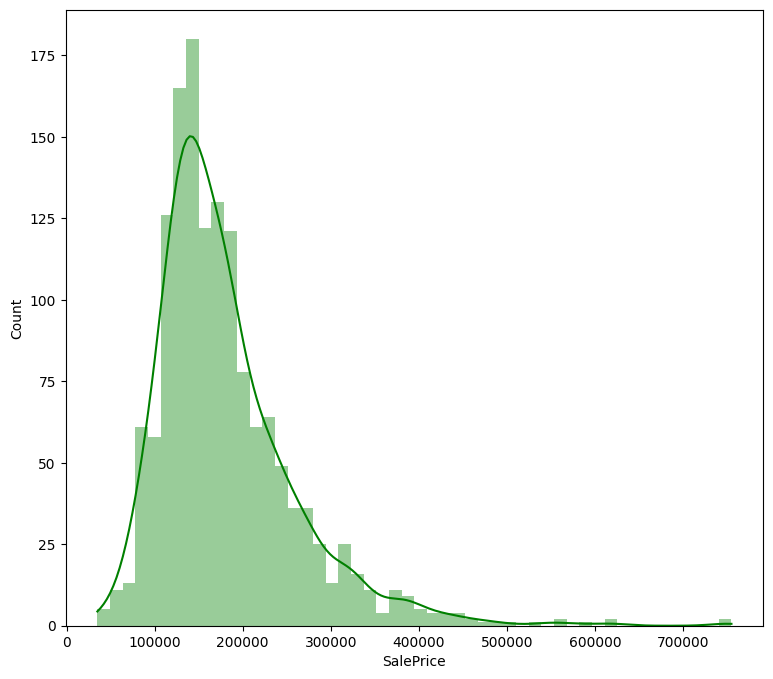

In [11]:
print(train_data['SalePrice'].describe())
plt.figure(figsize=(9, 8))
sns.histplot(train_data['SalePrice'], color='g', bins=50, kde=True, alpha=0.4, edgecolor=None)
#sns.distplot(train_data['SalePrice'], color='g', bins=50, hist_kws={'alpha': 0.4})

count      1438.000000
mean     175844.522253
std       67475.861228
min       34900.000000
25%      129500.000000
50%      161500.000000
75%      210000.000000
max      415298.000000
Name: SalePrice, dtype: float64


<Axes: xlabel='SalePrice', ylabel='Count'>

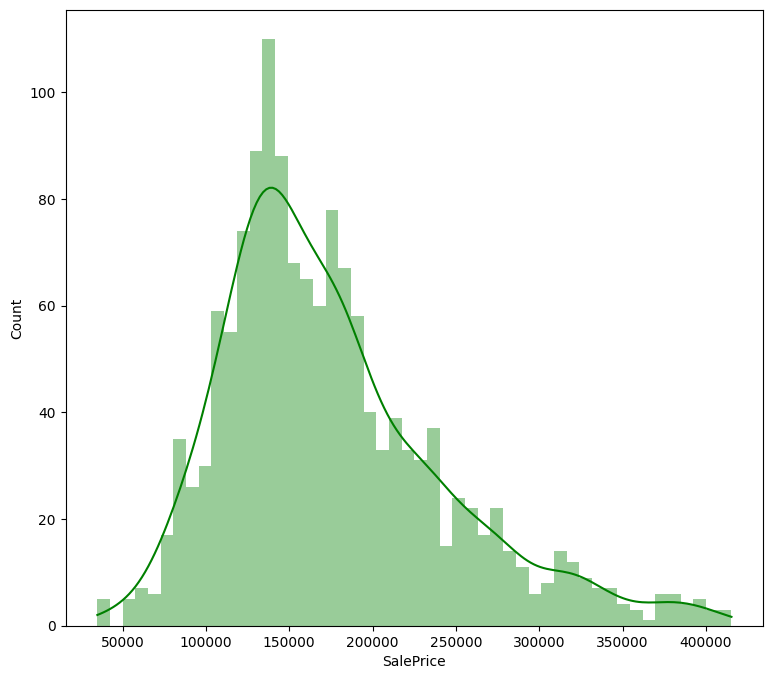

In [12]:
# Calculate mean and standard deviation
mean_sale_price = train_data['SalePrice'].mean()
std_sale_price = train_data['SalePrice'].std()

# Filter out outliers
train_data = train_data[(train_data['SalePrice'] >= mean_sale_price - 3 * std_sale_price) & 
                        (train_data['SalePrice'] <= mean_sale_price + 3 * std_sale_price)]

# Describe the filtered data
print(train_data['SalePrice'].describe())

# Plot the distribution of SalePrice after removing outliers
plt.figure(figsize=(9, 8))
sns.histplot(train_data['SalePrice'], color='g', bins=50, kde=True, alpha=0.4, edgecolor=None)

In [13]:
list(set(train_data.dtypes.tolist()))

[dtype('float64'), dtype('O'), dtype('int64')]

In [14]:
train_num = train_data.select_dtypes(include=['float64', 'int64'])
train_num.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,61,0,0,0,0,0,2,2008,208500
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,298,0,0,0,0,0,0,5,2007,181500
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,42,0,0,0,0,0,9,2008,223500
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,35,272,0,0,0,0,2,2006,140000
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,192,84,0,0,0,0,0,12,2008,250000


# Model building

In [15]:
# Adjust the unpacking to match the number of returned values
X_train, X_test, y_train, y_test, test_data, top_features = get_data(False, train_data, test_data)

# Now you can print top_features outside the function
print("Top 20 features used in the model:")
print(top_features)

Top 20 features based on correlation with SalePrice:
Index(['OverallQual', 'GrLivArea', 'ExterQual_TA', '1stFlrSF', 'YearBuilt',
       'FullBath', 'KitchenQual_TA', 'YearRemodAdd', 'ExterQual_Gd',
       'Foundation_PConc', 'TotRmsAbvGrd', 'GarageYrBlt', 'BsmtQual_TA',
       'BsmtQual_Ex', 'Fireplaces', 'HeatingQC_Ex', 'BsmtFinType1_GLQ',
       'GarageFinish_Unf', 'GarageFinish_Fin', 'MasVnrArea'],
      dtype='object')
Top 20 features used in the model:
Index(['OverallQual', 'GrLivArea', 'ExterQual_TA', '1stFlrSF', 'YearBuilt',
       'FullBath', 'KitchenQual_TA', 'YearRemodAdd', 'ExterQual_Gd',
       'Foundation_PConc', 'TotRmsAbvGrd', 'GarageYrBlt', 'BsmtQual_TA',
       'BsmtQual_Ex', 'Fireplaces', 'HeatingQC_Ex', 'BsmtFinType1_GLQ',
       'GarageFinish_Unf', 'GarageFinish_Fin', 'MasVnrArea'],
      dtype='object')


c:\Users\enorton\Downloads\Tools\Lib\site-packages\numpy\lib\_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\enorton\Downloads\Tools\Lib\site-packages\numpy\lib\_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [16]:
model = Sequential([
    Dense(64, activation="relu"),
    Dense(32, activation="relu"),
    Dense(16, activation="relu"),
    Dense(1)
])

model.compile(
    loss=MeanSquaredError(),
    optimizer=Adam(learning_rate=0.0006)
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)
history = model.fit(X_train, y_train, epochs=150, validation_data=(X_test, y_test), verbose=0, callbacks=early_stopping)

Restoring model weights from the end of the best epoch: 150.


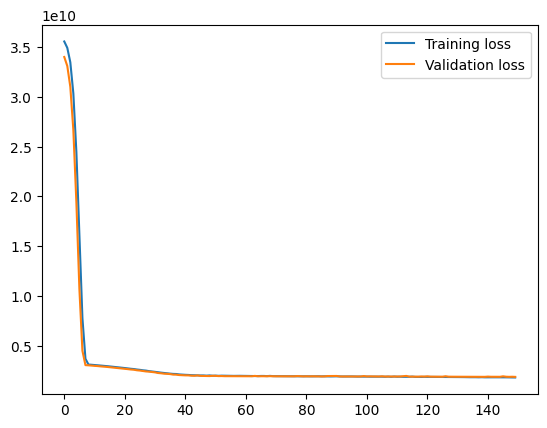

In [17]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

In [18]:
mean_squared_error(model.predict(X_test), y_test)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


np.float64(1853776674.0410657)

In [32]:
from sklearn.model_selection import GridSearchCV
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
import numpy as np

# Function to create the model
def create_model(neurons=128, dropout_rate=0.2, learning_rate=0.0001):
    model = Sequential([
        Dense(neurons, activation="relu"),
        Dropout(dropout_rate),
        Dense(64, activation="relu"),
        Dense(32, activation="relu"),
        Dense(1)
    ])
    
    model.compile(
        loss=MeanSquaredError(),
        optimizer=Adam(learning_rate=learning_rate)
    )
    
    return model

# Custom KerasRegressor class
from sklearn.metrics import mean_squared_error

class KerasRegressorCustom:
    def __init__(self, build_fn, epochs=150, batch_size=10, verbose=0):
        self.build_fn = build_fn
        self.epochs = epochs
        self.batch_size = batch_size
        self.verbose = verbose
        self.model = None

    def fit(self, X, y):
        self.model = self.build_fn()
        self.model.fit(X, y, epochs=self.epochs, batch_size=self.batch_size, verbose=self.verbose)

    def predict(self, X):
        return self.model.predict(X)

    def score(self, X, y):
        # Use mean squared error as the scoring metric
        y_pred = self.predict(X)
        return -mean_squared_error(y, y_pred)  # Return negative MSE for maximization

    def get_params(self, deep=True):
        return {
            'build_fn': self.build_fn,
            'epochs': self.epochs,
            'batch_size': self.batch_size,
            'verbose': self.verbose
        }

    def set_params(self, **params):
        for key, value in params.items():
            setattr(self, key, value)
        return self

# Wrap the model using the custom KerasRegressor
model = KerasRegressorCustom(build_fn=create_model)

# Define the parameter grid
param_grid = {
    'neurons': [64, 128, 256],  # Number of neurons in the first layer
    'dropout_rate': [0.1, 0.2, 0.3],  # Dropout rates
    'learning_rate': [0.0001, 0.001, 0.01]  # Learning rates
}

# Create GridSearchCV
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)

# Fit the model
grid_result = grid.fit(X_train, y_train)

# Print the best parameters and best score
print(f'Best: {grid_result.best_score_} using {grid_result.best_params_}')

Best: -1999197015.2421875 using {'dropout_rate': 0.3, 'learning_rate': 0.01, 'neurons': 64}


In [33]:
import numpy as np

# Extract the best parameters from the grid search
best_params = grid.best_params_
best_neurons = best_params['neurons']
best_dropout_rate = best_params['dropout_rate']
best_learning_rate = best_params['learning_rate']

# Create a new model with the best hyperparameters
final_model = create_model(neurons=best_neurons, 
                            dropout_rate=best_dropout_rate, 
                            learning_rate=best_learning_rate)

# Fit the final model on the training data
final_model.fit(X_train, y_train, epochs=150, batch_size=10, verbose=1)

# Evaluate the model on the test data
y_pred = final_model.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Final RMSE: {rmse}')

Epoch 1/150
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 16019153920.0000
Epoch 2/150
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3519995648.0000
Epoch 3/150
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2845246976.0000
Epoch 4/150
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2970225408.0000
Epoch 5/150
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2643342336.0000
Epoch 6/150
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2756784128.0000
Epoch 7/150
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2639306752.0000
Epoch 8/150
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2654457600.0000
Epoch 9/150
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2383451904.0000
Epoch 10/150
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2439443712.0000
Epoch 11/150
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2845388288.0000
Epoch 12/150
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2363124992.0000
Epoch 13/150
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2577311232

In [34]:
# Load the sample submission file
sample_submission_df = pd.read_csv('sample_submission.csv')

# Ensure the test data is correctly preprocessed
# Make predictions on the test data
predictions = model.predict(test_data)

# Assign predictions to the 'SalePrice' column
sample_submission_df['SalePrice'] = predictions

# Save the submission file
sample_submission_df.to_csv('submission.csv', index=False)

# Display the first few rows of the submission file
sample_submission_df.head()

AttributeError: 'NoneType' object has no attribute 'predict'

In [35]:
import pandas as pd

# Assuming you have already defined and fitted the final model
# Fit the final model on the entire training data
final_model.fit(X_train, y_train, epochs=150, batch_size=10, verbose=1)

# Make predictions on the test data
predictions = final_model.predict(test_data)

# Load the sample submission file
sample_submission_df = pd.read_csv('sample_submission.csv')

# Assign predictions to the 'SalePrice' column
sample_submission_df['SalePrice'] = predictions

# Save the submission file
sample_submission_df.to_csv('submission.csv', index=False)

# Display the first few rows of the submission file
print(sample_submission_df.head())

Epoch 1/150
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1553831552.0000
Epoch 2/150
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1898360576.0000
Epoch 3/150
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1474698112.0000
Epoch 4/150
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1801780352.0000
Epoch 5/150
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1983292416.0000
Epoch 6/150
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1385298048.0000
Epoch 7/150
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1384521728.0000
Epoch 8/150
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1425074176.0000
Epoch 9/150
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1442377984.0000
Epoch 10/150
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1277754368.0000
Epoch 11/150
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1428088576.0000
Epoch 12/150
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1965889152.0000
Epoch 13/150
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1671941632.